# ML Pipeline Preparation

### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload # auto reload packages for quick testing
%autoreload 2

In [2]:
# load data from database
from sqlalchemy import create_engine
engine = create_engine('sqlite:///data/DisasterResponse.db')
df = pd.read_sql("SELECT * FROM RawDataClean", engine)

In [3]:
df.head(3)

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2. Tokenization function to process text data

In [4]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import re

stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

In [5]:
def tokenize(text):
    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # tokenize text
    tokens = word_tokenize(text)
    
    # lemmatize andremove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return tokens

### 3. Build a machine learning pipeline

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import jaccard_score
from sklearn.pipeline import Pipeline

In [7]:
base_lr = LogisticRegression(max_iter = 500, class_weight = 'balanced')
pipe = Pipeline([
    ('tfidf_vect', TfidfVectorizer(tokenizer = tokenize)),
    ('clf', OneVsRestClassifier(base_lr)),
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [8]:
from sklearn.model_selection import train_test_split
categories = df.drop(columns = ['id', 'message', 'original', 'genre'])
x, y = df['message'].to_numpy(), categories.to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle = True, random_state=0)
x_train.shape, y_train.shape, y.shape, x.shape

((18326,), (18326, 35), (26180, 35), (26180,))

In [9]:
pipe.fit(x_train, y_train)
y_score = pipe.predict_proba(x_test)

### 5. Model evaluation
Report the f1 score, precision and recall for each output category of the dataset.

In [10]:
y_pred = pipe.predict(x_test) # prediction with default threshold 0.5

In [11]:
from sklearn.metrics import classification_report

target_names = categories.columns.values
report = classification_report(y_test, y_pred, target_names = target_names, output_dict=True)
report = pd.DataFrame(report).transpose()
report[(report.index == 'related') | (report['precision'] == 0.0) | (report.index == 'macro avg')]

/Users/empyriumz/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/empyriumz/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
related,0.910684,0.823192,0.864731,5933.0
macro avg,0.385755,0.588224,0.455902,24501.0


In [16]:
report[['recall', 'support']].sort_values(by ='support')[:10]

,recall,support
tools,0.117647,34.0
shops,0.055556,36.0
offer,0.097561,41.0
missing_people,0.366197,71.0
fire,0.488372,86.0
aid_centers,0.363636,88.0
hospitals,0.404255,94.0
clothing,0.622951,122.0
security,0.257576,132.0
cold,0.638889,144.0


In [17]:
y_pred_adj = np.where(y_score > 0.2, 1, 0) # adjusting prediction by tuning threshold
report_adj = classification_report(y_test, y_pred_adj, target_names = target_names, output_dict=True)
report_adj = pd.DataFrame(report_adj).transpose()
report_adj[(report_adj.index == 'related') | (report_adj['precision'] == 0.0) | (report_adj.index == 'macro avg')]

/Users/empyriumz/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/empyriumz/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
related,0.805954,0.976572,0.883097,5933.0
macro avg,0.182605,0.783036,0.276782,24501.0


In [18]:
report_adj.sort_values(by = ['support', 'f1-score'])

,precision,recall,f1-score,support
tools,0.016234,0.294118,0.030769,34.0
shops,0.019656,0.222222,0.036117,36.0
offer,0.026316,0.219512,0.046997,41.0
missing_people,0.028310,0.478873,0.053459,71.0
fire,0.081433,0.581395,0.142857,86.0
aid_centers,0.051613,0.636364,0.095482,88.0
hospitals,0.077465,0.585106,0.136816,94.0
clothing,0.145270,0.704918,0.240896,122.0
security,0.034878,0.553030,0.065618,132.0
cold,0.115499,0.812500,0.202247,144.0


We see from those anomalous predicted results with precision = recall = 0 all come from the categories where the positive samples are scarce. So the classifier has the tendency to label every message with negative label.

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
threshold = dict()
average_precision = dict()
n_classes = 35
for i in range(n_classes):
    precision[i], recall[i], threshold[i] = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

In [ ]:
# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

In [ ]:
# A "macro-average": quantifying score on all classes jointly
precision["macro"], recall["macro"], threshold["macro"] = precision_recall_curve(y_test.ravel(),
    y_score.ravel())
average_precision["macro"] = average_precision_score(y_test, y_score,
                                                     average="macro")
print('Average precision score, macro-averaged over all classes: {0:0.2f}'
      .format(average_precision["macro"]))

In [ ]:
plt.figure()
plt.step(recall['macro'], precision['macro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Average precision score, macro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["macro"]))
plt.show()

### Feature engeering: Simple sampling method

As we can see before the dataset is very imbalanced. A lot of categories only have very few labels. Now we try to upsample those sparse samples. It is a little bit tricky though. For example a message may have labels which are both unpopular and popular. 

Now we first use a simple sample strategy by upsampling messages with unpopular labels, regardless of whether the message have popular labels.

In [ ]:
# # first we only consider related messages
sub_cats = categories[categories['related'] == 1].drop(columns = 'related')
# counts how many positive labels within each category
label_counts = sub_cats.sum().values
criteria = label_counts/df.shape[0] < 0.05
sparse_label = list(sub_cats.columns[criteria])

Note here we set the number of bootstrap sampling to be equal to the number of messages in the most popular category.

In [ ]:
upsample_num = np.sort(label_counts)[::-1][0]
msg_simple_sample = df[df[sparse_label].any(axis = 1)].sample(n = upsample_num, replace = True, random_state = 0)
df_simple_sample = pd.concat([msg_simple_sample, df[~df[sparse_label].any(axis = 1)]])

To simplify the notebook, we import the class ML_classifier which makes model building, testing, and visualization much easier

In [ ]:
from models.train_classifier import ML_classifier

model_simple_sample = ML_classifier(df_simple_sample)
model_simple_sample.plot_dist()

If we compare carefully, these is indeed some increase of instances within those minority groups. 

In [ ]:
model_simple_sample.fit()
model_simple_sample.evaluate()

In [ ]:
report_simple_sample = model_simple_sample.report
report_simple_sample[(report_simple_sample.index == 'related') | (report_simple_sample['precision'] == 0.0) | (report_simple_sample.index == 'macro avg')]

We can see an impressive improvement of our model by using this simple upsampling trick. The number of categories with f1-score = 0 also decreases.

### More Sophiscated Resample Strategy

We can still make progress by using a more sophiscated sampling method, i.e., only upsampling the messages with unpopular labels.

In [ ]:
# we define the top-3 most labels as popular
pop_label = list(sub_cats.sum().sort_values(ascending = False)[:3].index)
# messages without any label in those popular categories 
sparse_msg = sub_cats[~sub_cats[pop_label].any(axis = 1)]
sparse_msg.sum(axis = 1).value_counts()

We see most messages actually don't get any labels. Since we want to improve our f1 score, we need to put more postive samples in our dataset. So we will only up-sample messages with at least 1 positive label within the unpopular groups.

In [ ]:
# messages to be upsampled
# we exclude messages without any labels other than 'related' = 1
msg_to_sample = sparse_msg[(sparse_msg.sum(axis = 1) > 0)]

Here we again use the same up-sampling number.

In [ ]:
# upsampling 
# msg_under_sample = msg_to_sample.sample(n = label_counts[0], replace = True, random_state = 0)
msg_under_sample = msg_to_sample.sample(n = upsample_num, replace = True, random_state = 0)
df_sample = pd.concat([df.loc[msg_under_sample.index], df.loc[list(set(df.index.values) - set(msg_to_sample.index.values))]])

In [ ]:
model_sample = ML_classifier(df_sample)
model_sample.plot_dist()

In [ ]:
model_sample.fit()
model_sample.evaluate()

In [ ]:
report_sample = model_sample.report
report_sample[(report_sample.index == 'related') | (report_sample['precision'] == 0.0) | (report_sample.index == 'macro avg')]

The more advanced sampling strategy works much better!

In [ ]:
y_score_sample = model_sample.model.predict_proba(model_sample.x_test)

In [ ]:
y_pred_adj = np.where(y_score_sample > 0.25, 1, 0)

In [ ]:
report_sample_adj = classification_report(model_sample.y_test, y_pred_adj, target_names = target_names, output_dict=True)
report_sample_adj = pd.DataFrame(report_sample_adj).transpose()
report_sample_adj[(report_sample_adj.index == 'related') | (report_sample_adj['precision'] == 0.0) | (report_sample_adj.index == 'macro avg')]

In [ ]:
report_sample_adj.sort_values(by = ['support', 'f1-score'])

### Data leakage
The upsampling procedure above will lead to data leakage since the distribution of test data also get distorted

In [28]:
from models.train_classifier import ML_classifier

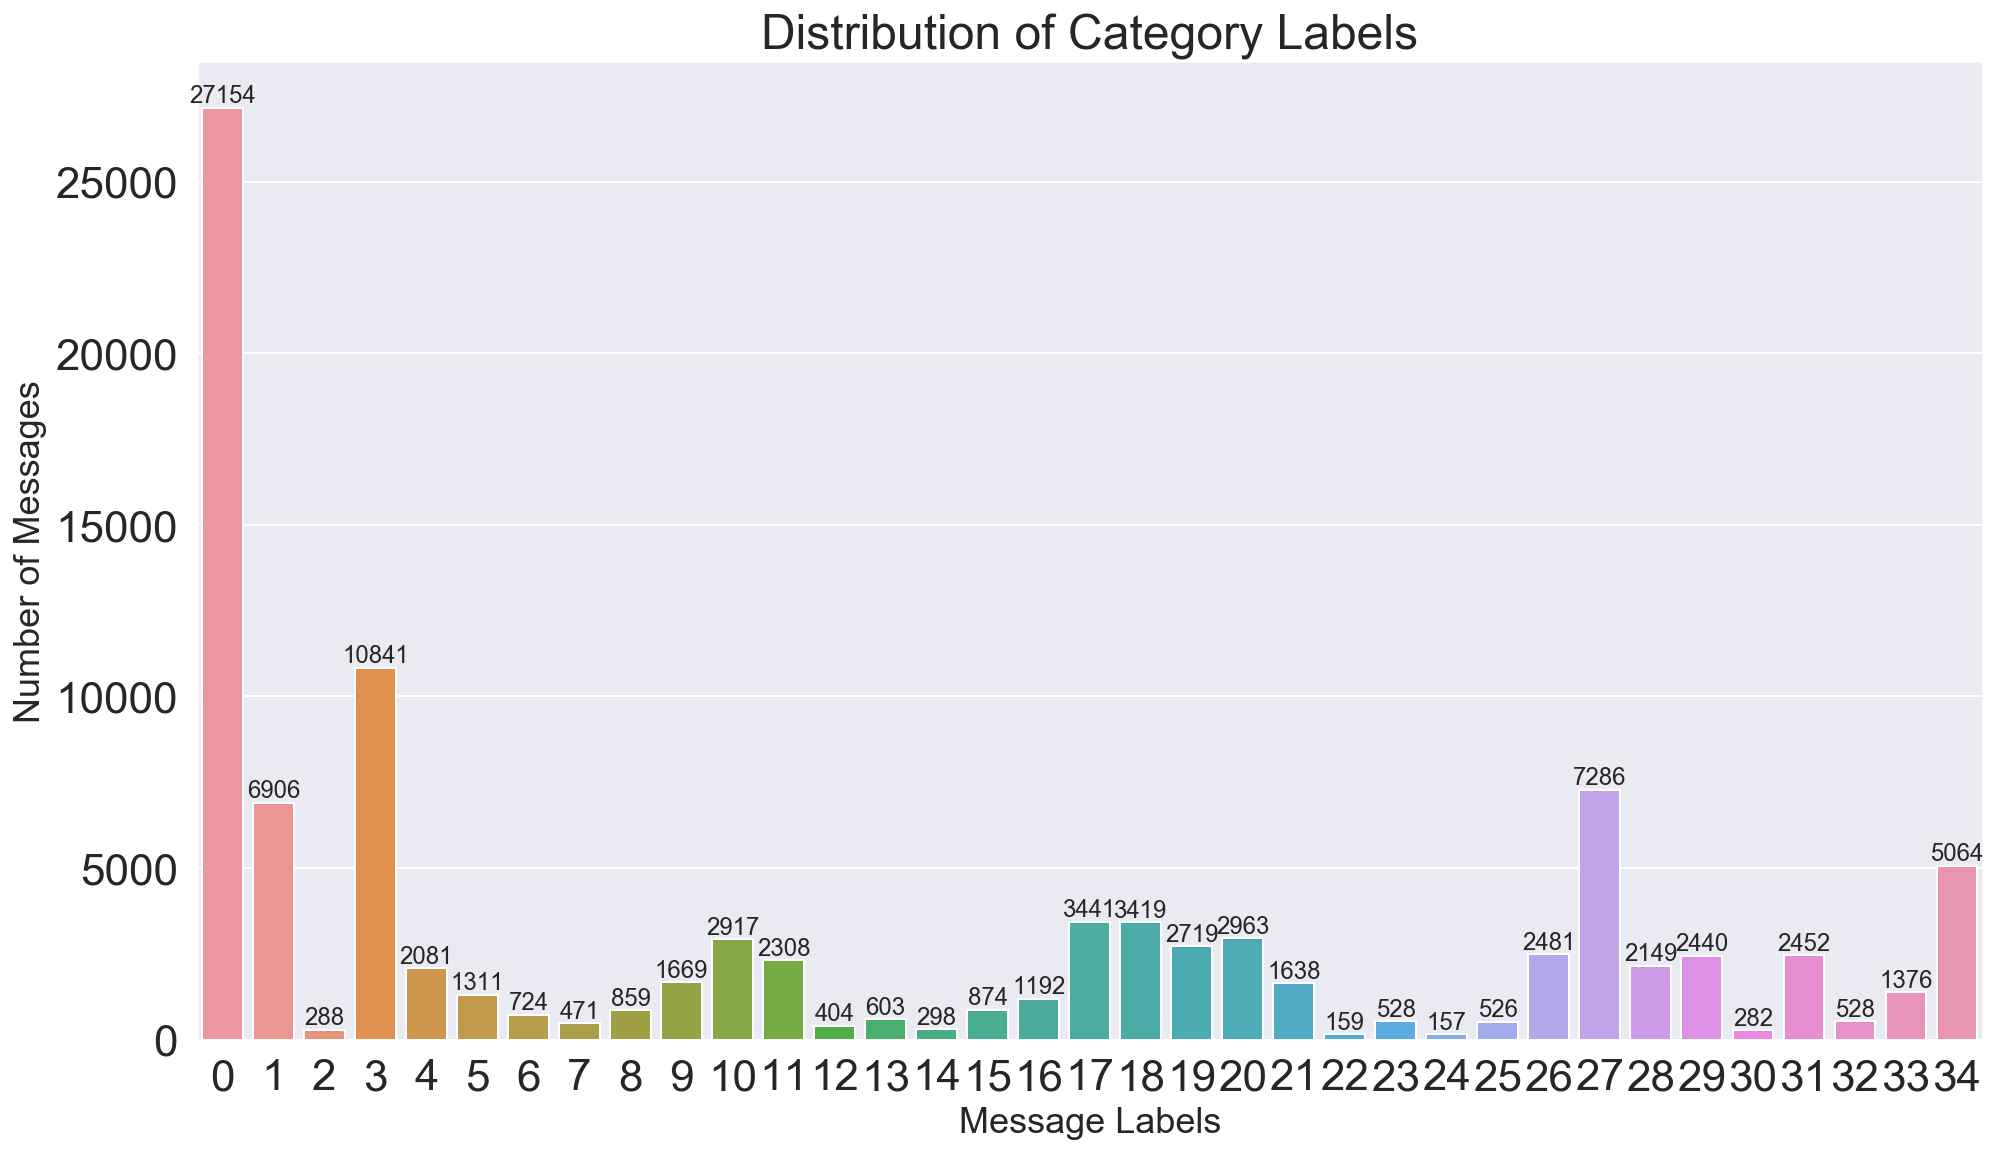

In [29]:
model_sample = ML_classifier(df)
model_sample.plot_dist()

In [30]:
model_sample.fit()
model_sample.evaluate()

/Users/empyriumz/miniconda3/lib/python3.7/site-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 2.46s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


The Jaccard score on the test data set is: 0.349151961797921


/Users/empyriumz/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
model_sample.report[['recall', 'support', 'f1-score']].sort_values(by = 'support')[:10]

,recall,support,f1-score
shops,0.071429,28.0,0.055556
offer,0.081081,37.0,0.075000
tools,0.152174,46.0,0.091503
fire,0.455696,79.0,0.365482
aid_centers,0.252747,91.0,0.179688
hospitals,0.397849,93.0,0.289062
missing_people,0.340426,94.0,0.230216
clothing,0.738095,126.0,0.567073
security,0.196970,132.0,0.106776
cold,0.590909,154.0,0.465473


In [32]:
y_score_sample = model_sample.model.predict_proba(model_sample.x_test)

In [33]:
y_pred_adj = np.where(y_score_sample > 0.2, 1, 0) # adjusting prediction by tuning threshold

In [36]:
report_sample = classification_report(model_sample.y_test, model_sample.y_pred, target_names = target_names, output_dict=True)
report_sample = pd.DataFrame(report_sample).transpose()
report_sample[(report_sample.index == 'related') | (report_sample['precision'] == 0.0) | (report_sample.index == 'macro avg')]

/Users/empyriumz/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/empyriumz/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
related,0.926197,0.786723,0.850782,5950.0
macro avg,0.387022,0.570717,0.452975,24884.0


In [37]:
report_sample_adj = classification_report(model_sample.y_test, y_pred_adj, target_names = target_names, output_dict=True)
report_sample_adj = pd.DataFrame(report_sample_adj).transpose()
report_sample_adj[(report_sample_adj.index == 'related') | (report_sample_adj['precision'] == 0.0) | (report_sample_adj.index == 'macro avg')]

/Users/empyriumz/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/empyriumz/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
related,0.829592,0.956471,0.888525,5950.0
macro avg,0.191291,0.764921,0.288503,24884.0


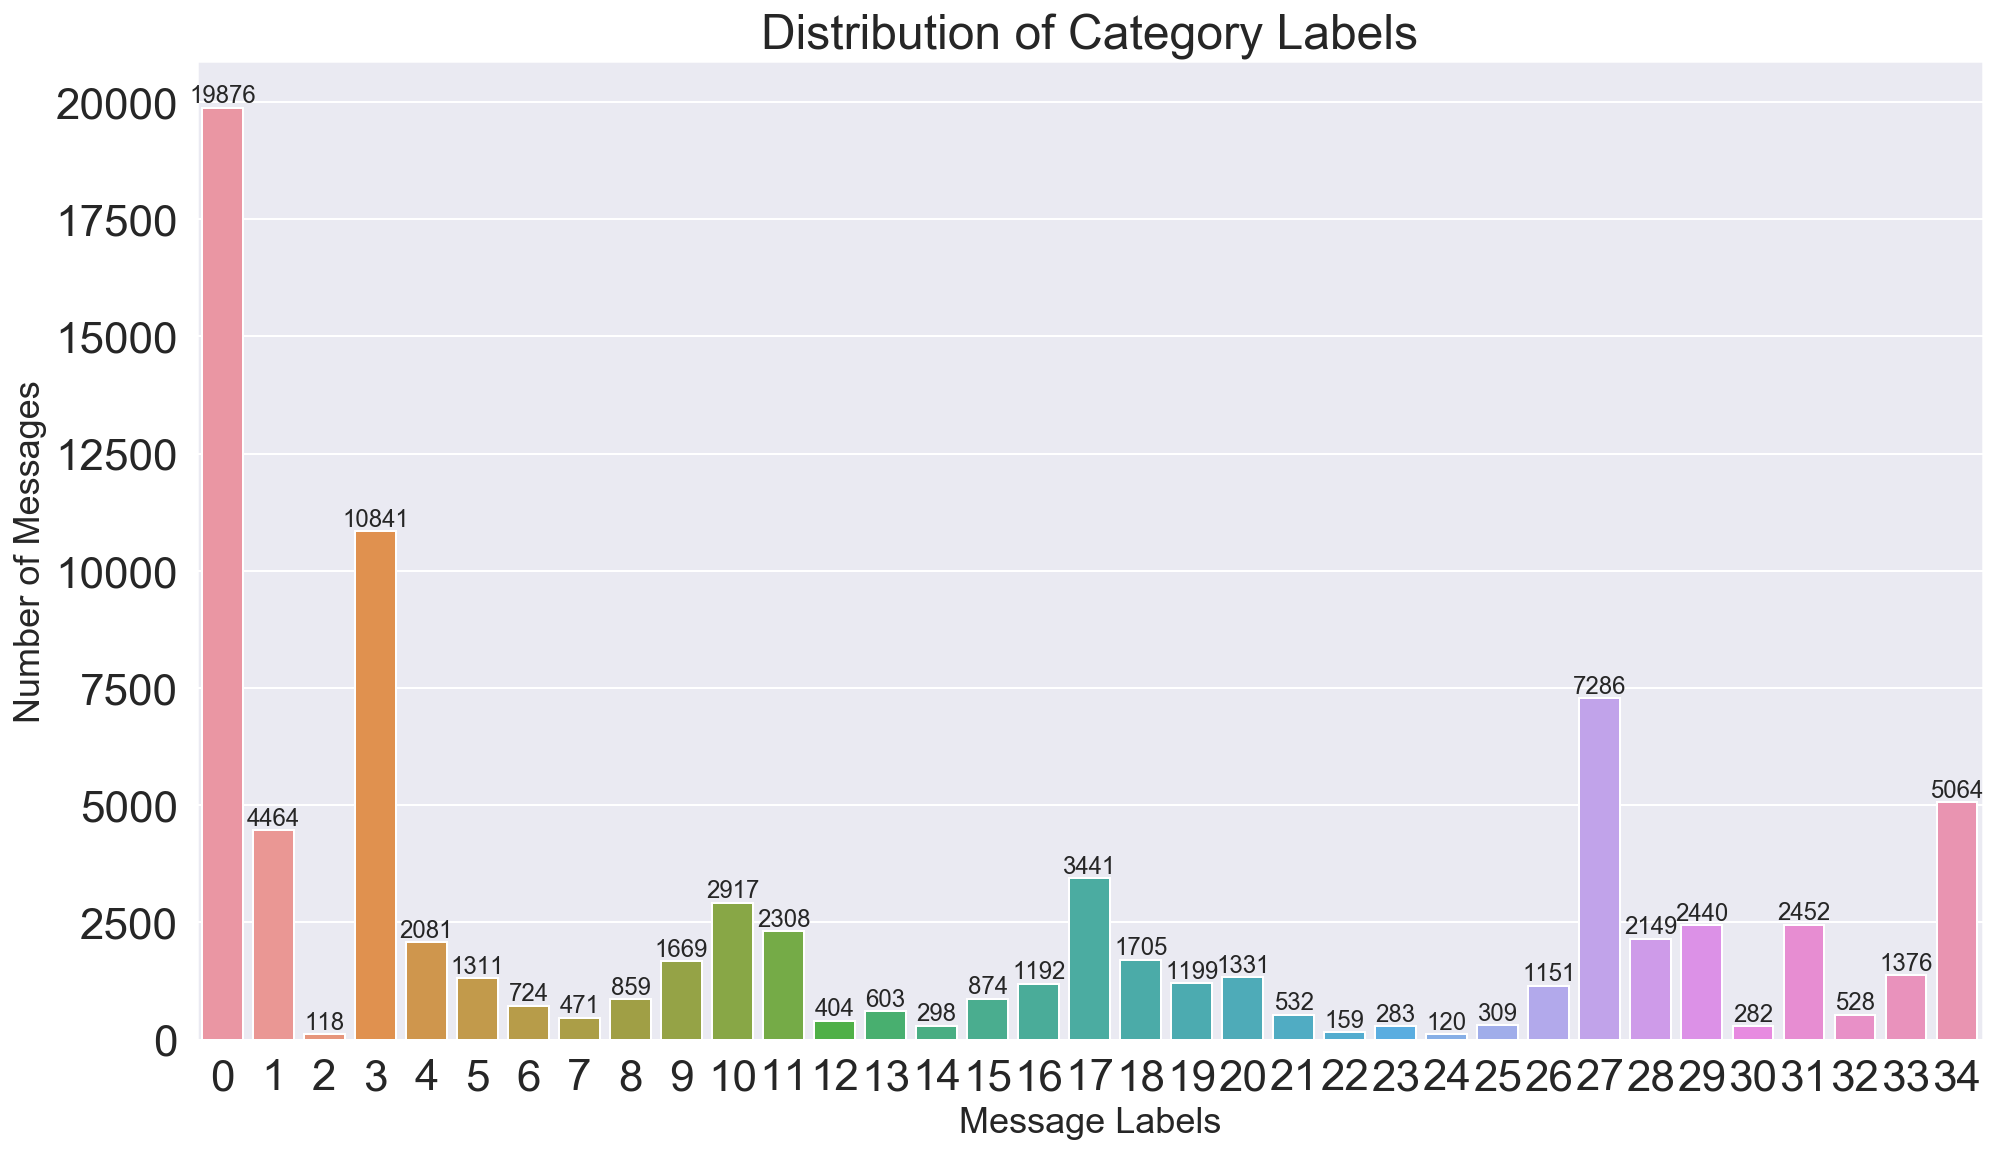

In [35]:
model = ML_classifier(df, upsample = False)

In [38]:
model.fit()
model.evaluate()
report = classification_report(model.y_test, model.y_pred, target_names = target_names, output_dict=True)
report = pd.DataFrame(report).transpose()
report[(report.index == 'related') | (report['precision'] == 0.0) | (report.index == 'macro avg')]

/Users/empyriumz/miniconda3/lib/python3.7/site-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 2.53s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


The Jaccard score on the test data set is: 0.35675408041378504


/Users/empyriumz/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/empyriumz/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/empyriumz/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
related,0.910701,0.823222,0.864755,5934.0
macro avg,0.385755,0.588208,0.455903,24504.0


In [43]:
y_score = model.model.predict_proba(model.x_test)
y_pred_adj = np.where(y_score > 0.1, 1, 0) # adjusting prediction by tuning threshold
report_adj = classification_report(model.y_test, y_pred_adj, target_names = target_names, output_dict=True)
report_adj = pd.DataFrame(report_adj).transpose()
report_adj[(report_adj.index == 'related') | (report_adj['precision'] == 0.0) | (report_adj.index == 'macro avg')]

/Users/empyriumz/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/empyriumz/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
related,0.772072,0.993259,0.868809,5934.0
macro avg,0.117967,0.883199,0.188552,24504.0


In [45]:
report_adj.sort_values(by='support')

,precision,recall,f1-score,support
tools,0.008820,0.470588,0.017316,34.0
shops,0.013219,0.472222,0.025719,36.0
offer,0.025434,0.536585,0.048565,41.0
missing_people,0.015311,0.633803,0.029900,71.0
fire,0.029150,0.686047,0.055924,86.0
aid_centers,0.030351,0.875000,0.058667,88.0
hospitals,0.032035,0.691489,0.061234,94.0
clothing,0.067199,0.827869,0.124308,122.0
security,0.022261,0.780303,0.043286,132.0
cold,0.043433,0.875000,0.082759,144.0
